# Time Series Forecasting of VTSAX Prices - Neural

This is the bonus part of my time-series project on analysing VTSAX adjusted closing prices. The analysis of the data has been done in my first part of the project, and the notebook for it can be found within the same folder. This part will be strictly to implement recurrent neural networks to assess feasibility for small datasets.
<br>
<br>
As with the previous part, I will be using the monthly data of VTSAX Adjusted Closing price from Yahoo Finance. I am using the first observation of each month as the price data for that month.

In [397]:
# Load required libraries
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt

# Data Preparation

In [233]:
# Importing the dataset
dataset = pd.read_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Time Series Project\VTSAX_dataset.csv").drop("Unnamed: 0", axis = 1)

In [234]:
# Creating monthly dataset
# Drop the Volume column
dataset = dataset.drop("Volume", axis = 1)

# Convert all but the Date column to be a numerical column and the Date column to be a datetime column.
dataset["Date"] = pd.to_datetime(dataset["Date"])
numerical_columns = list(dataset.drop("Date", axis = 1).columns)
for column in numerical_columns:
    dataset[column] = pd.to_numeric(dataset[column])

# Partitioning dataset to training and test
dataset["year"] = dataset["Date"].dt.year
volatile_data = dataset[dataset["year"] == 2020]
test_set = dataset[dataset["year"] == 2019]
dataset = dataset[dataset["year"] < 2019]

# Create a monthly dataset by extracting the first rows of every month for every year from the original dataset
dataset["month"] = dataset["Date"].dt.month
dataset["day"] = dataset["Date"].dt.day
df1 = dataset.set_index('Date')
df1.sort_index(inplace=True)

monthly_data = df1.groupby(pd.Grouper(freq = 'MS')).nth(0)

monthly_data.reset_index(inplace = True)


In [238]:
# Taking only the relevant columns
monthly_data = monthly_data[["Date", "Adj Close"]]
# Taking out the first row to make the dataset containing 217 inputs, because 218 is a difficult number to divide into batches.
adj = monthly_data["Adj Close"][1:]

In [239]:
# Creating the y_test. y_test will  be 2019 values, and will be compared with y_pred, which will be the next 12 predictions when the 
# model predicts next 12 predictions given data from 2000 - 2018

test_set["month"] = test_set["Date"].dt.month
test_set["day"] = test_set["Date"].dt.day
df1 = test_set.set_index('Date')
df1.sort_index(inplace=True)

monthly_test = df1.groupby(pd.Grouper(freq = 'MS')).nth(0)

monthly_test.reset_index(inplace = True)

# Converting relevant column as an array
y_test = monthly_test["Adj Close"].values


In [250]:
# Taking out the first row to make the dataset containing 217 inputs, because 218 is a difficult number to divide into batches.
adj = monthly_data["Adj Close"][1:]
adj = adj.values.reshape(7,31)

I chose to partition the 217 observations into 7 batches of 31 observations. For every batch, the first 19 observations will be in the input sets and the last 12 observations will be allocated into the output set. This is because I want to configure the model to predict 12 outputs, which will be the model's predictions of the adjusted closing price for every month of 2019.

In [271]:
# Partition data into training and validation sets. 2019 data will be used as test set
X_train, y_train = adj[:6,:19], adj[:6,-12:]
X_val, y_val = adj[-1,:19], adj[-1,-12:]

Scaling of numerical data is highly recommended for deep learning models in order to keep the models stable and to optimize efficiently. I will use Scikit-Learn's MinMaxScaler to scale the data.

In [ ]:
# Scaling the inputs and outputs 
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
y_train = y_scale.fit_transform(y_train)
# Transforming validation sets. Adding a new dimension to match dimensions of the training set
X_val = scale.transform(X_val[np.newaxis])
y_val = y_scale.transform(y_val[np.newaxis])

# Implement LSTM for 12 Month Forecasting

Long Short-Term Memory is a type of recurrent neural network (RNN) cell that was created as a remedy for RNN's biggest problem, which is its lacking ability to "remember" older data. As the RNN is fed more data, the effect of the first inputs to the network on subsequent outputs diminish. For example, the output of the RNN for the third time step uses more information from the input of the first time step than the output for the tenth time step does. Therefore, classic RNNs lacked the ability to process long sequences of information. 
<br>
<br>
To tackle this short memory problem, the LSTM cell was formulated. Though many machine learning practitioners across many industries still use LSTM, the cell was proposed almost quarter of a century ago. At every time step after the first, the LSTM cell takes inputs from the input data, the hidden state from the previous time step, and the cell state from the previous time step. The hidden state is the short-term information derived from analyzing current time step data, while the cell state carries the long-term information that is subject to being updated with relevant information at each time step. The network trains four different neural networks, each with a separate function. One network is trained to determine which information should be forgotten, in order to keep only the relevant information to be propagated to future steps. Another network is used to determine the output for that time step by analyzing the current input data with the hidden state from the previous time step. The third network is trained to control which part of the output from the previous network explained should be used to update the cell state. The fourth and last neural netowrk controls which part of the long-term state should be read and outputted as both the output of the cell at the current state, and also as the hidden state for the next time step.
<br>
<br>
The capability of LSTM to process long sequences of data makes it a suitable deep learning model for time series. Let's see how this model performs on a monthly dataset with small sample size.

In [284]:
# Reshaping X to tensors
X_train = X_train.reshape(6, 19, 1)
X_val = X_val.reshape(1, 19, 1)

In [444]:
# Implement a LSTM Model.

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = (19,1)),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.LSTM(20),
    keras.layers.Dense(12)
])

model.compile(loss="mse", optimizer="adam")


In [445]:
# Fit the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.2682 - val_loss: 2.5026
Epoch 2/30
1/1 [==============================] - 0s 67ms/step - loss: 0.2608 - val_loss: 2.4516
Epoch 3/30
1/1 [==============================] - 0s 48ms/step - loss: 0.2533 - val_loss: 2.3989
Epoch 4/30
1/1 [==============================] - 0s 49ms/step - loss: 0.2456 - val_loss: 2.3438
Epoch 5/30
1/1 [==============================] - 0s 56ms/step - loss: 0.2375 - val_loss: 2.2855
Epoch 6/30
1/1 [==============================] - 0s 51ms/step - loss: 0.2290 - val_loss: 2.2234
Epoch 7/30
1/1 [==============================] - 0s 54ms/step - loss: 0.2199 - val_loss: 2.1569
Epoch 8/30
1/1 [==============================] - 0s 52ms/step - loss: 0.2103 - val_loss: 2.0856
Epoch 9/30
1/1 [==============================] - 0s 54ms/step - loss: 0.1999 - val_loss: 2.0095
Epoch 10/30
1/1 [==============================] - 0s 55ms/step - loss: 0.1889 - val_loss: 1.9287
Epoch 11/30
1/1 [==============

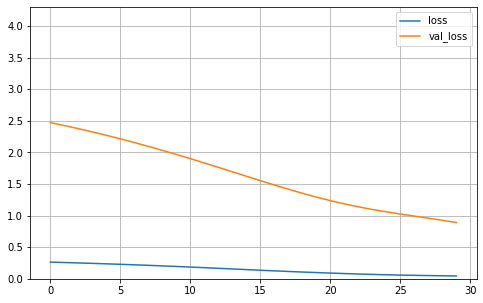

In [413]:
# Plot learning curve
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.ylim(0,4.3)
plt.show()

In [421]:
# Creating predictions using the 2018 data to forecast 2019 data
y_pred = model.predict(X_val)

In [414]:
# Adding regularization to reduce overfitting
model2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = (19,1), recurrent_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.LSTM(20),
    keras.layers.Dense(12)
])

model2.compile(loss="mse", optimizer="adam")

In [415]:
# Fit the model
history = model2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.9035 - val_loss: 4.2593
Epoch 2/30
1/1 [==============================] - 0s 49ms/step - loss: 1.8772 - val_loss: 4.1935
Epoch 3/30
1/1 [==============================] - 0s 50ms/step - loss: 1.8513 - val_loss: 4.1282
Epoch 4/30
1/1 [==============================] - 0s 48ms/step - loss: 1.8257 - val_loss: 4.0631
Epoch 5/30
1/1 [==============================] - 0s 47ms/step - loss: 1.8003 - val_loss: 3.9975
Epoch 6/30
1/1 [==============================] - 0s 54ms/step - loss: 1.7751 - val_loss: 3.9311
Epoch 7/30
1/1 [==============================] - 0s 51ms/step - loss: 1.7499 - val_loss: 3.8635
Epoch 8/30
1/1 [==============================] - 0s 49ms/step - loss: 1.7248 - val_loss: 3.7942
Epoch 9/30
1/1 [==============================] - 0s 49ms/step - loss: 1.6996 - val_loss: 3.7226
Epoch 10/30
1/1 [==============================] - 0s 48ms/step - loss: 1.6743 - val_loss: 3.6484
Epoch 11/30
1/1 [==============

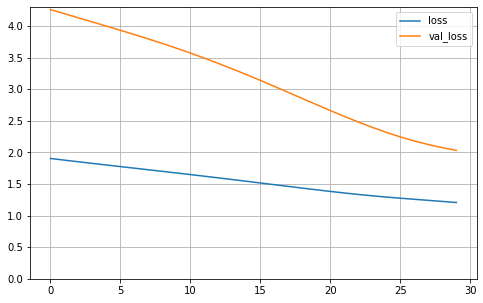

In [416]:
# Plot learning curve for regularized model 
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.ylim(0,4.3)
plt.show()

In [425]:
# Creating predictions using the 2018 data to forecast 2019 data
y_pred2 =model2.predict(X_val)

In [427]:
# Adding dropout regularization to reduce overfitting
model3 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = (19,1)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.LSTM(20),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(12)
])

model3.compile(loss="mse", optimizer="adam")

In [428]:
# Fit the model
history = model3.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.2808 - val_loss: 2.6286
Epoch 2/30
1/1 [==============================] - 0s 47ms/step - loss: 0.2738 - val_loss: 2.5988
Epoch 3/30
1/1 [==============================] - 0s 50ms/step - loss: 0.2762 - val_loss: 2.5705
Epoch 4/30
1/1 [==============================] - 0s 52ms/step - loss: 0.2661 - val_loss: 2.5415
Epoch 5/30
1/1 [==============================] - 0s 48ms/step - loss: 0.2692 - val_loss: 2.5127
Epoch 6/30
1/1 [==============================] - 0s 52ms/step - loss: 0.2596 - val_loss: 2.4822
Epoch 7/30
1/1 [==============================] - 0s 48ms/step - loss: 0.2552 - val_loss: 2.4504
Epoch 8/30
1/1 [==============================] - 0s 45ms/step - loss: 0.2502 - val_loss: 2.4169
Epoch 9/30
1/1 [==============================] - 0s 59ms/step - loss: 0.2508 - val_loss: 2.3825
Epoch 10/30
1/1 [==============================] - 0s 53ms/step - loss: 0.2357 - val_loss: 2.3457
Epoch 11/30
1/1 [==============

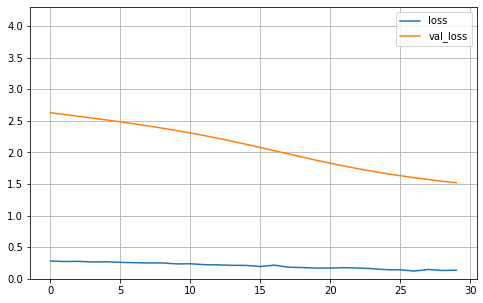

In [432]:
# Plot learning curve for dropout regularized model 
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.ylim(0,4.3)
plt.show()

In [430]:
# Creating predictions using the 2018 data to forecast 2019 data
y_pred3 =model3.predict(X_val)

# Evaluating model performance

The models predicted the adjusted closing prices of VTSAX for 2019 by using 2018 data and predicting the price for the next 12 months. So far, we have three models that have made their predictions. Now, we will unscale the predictions back to dollars, and compute the MAPE for each prediction.

In [437]:
# Reverse the scaling for the predictions
y_pred_actual = y_scale.inverse_transform(y_pred)
y_pred2_actual = y_scale.inverse_transform(y_pred2)
y_pred3_actual = y_scale.inverse_transform(y_pred3)


In [515]:
# Using df1 from earlier cell to recreate monthly test set.
monthly_test = df1.groupby(pd.Grouper(freq = 'MS')).nth(0)

# Using a clone function to create a dataset to append predictions to for visualization
monthly_clone = pd.DataFrame.copy(monthly_test)

# Preprocessing of data for visualization
full_monthly_test = monthly_test[["Adj Close"]]

new_full = monthly_data.set_index("Date")
new_full = new_full[["Adj Close"]]

# Creating a master dataframe used for visualization
full_data = pd.concat([new_full,full_monthly_test], axis = 0)

In [525]:
# Adding predictions to the monthly test data
monthly_clone["Predictions"] = y_pred_actual.reshape(12)

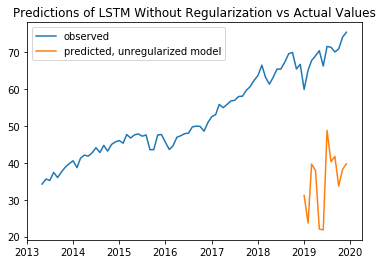

In [531]:
# Plotting predictions for first model
plt.plot(full_data["Adj Close"][150:], label='observed')
plt.plot(monthly_clone["Predictions"], label = "predicted, unregularized model")
plt.title("Predictions of LSTM Without Regularization vs Actual Values")
plt.legend(loc = "best")
plt.show()

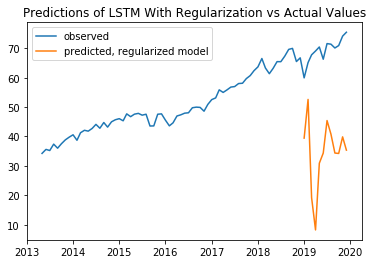

In [532]:
# Adding predictions from the second model to the monthly test data
monthly_clone["Predictions"] = y_pred2_actual.reshape(12)

# Plotting predictions for second model
plt.plot(full_data["Adj Close"][150:], label='observed')
plt.plot(monthly_clone["Predictions"], label = "predicted, regularized model")
plt.title("Predictions of LSTM With Regularization vs Actual Values")
plt.legend(loc = "best")
plt.show()

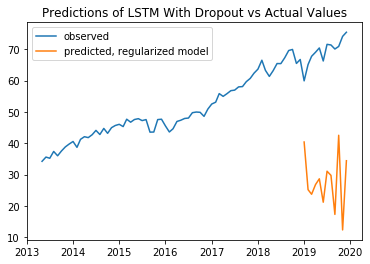

In [533]:
# Adding predictions from the third model to the monthly test data
monthly_clone["Predictions"] = y_pred3_actual.reshape(12)

# Plotting predictions for second model
plt.plot(full_data["Adj Close"][150:], label='observed')
plt.plot(monthly_clone["Predictions"], label = "predicted, regularized model")
plt.title("Predictions of LSTM With Dropout vs Actual Values")
plt.legend(loc = "best")
plt.show()

As you can see, the prediction accuracies are abysmal.

In [438]:
def get_mape(preds, actual):
    perc_error = 100*(preds - actual)/actual
    mape = np.mean(np.abs(perc_error))
    return mape

In [441]:
print("Unregularized model MAPE: ",get_mape(y_pred_actual, y_test))
print("Regularized model MAPE: ",get_mape(y_pred2_actual, y_test))
print("Dropout model MAPE: ",get_mape(y_pred3_actual, y_test))


Unregularized model MAPE:  47.25922880164779
Regularized model MAPE:  44.907027380295254
Dropout model MAPE:  59.584988633509454


The MAPE for these neural networks are ten times higher than the MAPE that was derived from the ARIMA models. The ARIMA(2,1,2)(1,0,1) model scored a MAPE of 4.05, which is significantly lower than any of the MAPE derived from the neural network models. With that being said, the model with the recurrent regularizer scored the lowest MAPE of about 45, although the unregularized model performs very similarly. Due to the stochastic nature of neural network, furthur statistical investigation needs to be made to declare the best performing model.

# Significance Testing for Model Selection

I will conduct a paired t test to determine whether the unregularized or the regularized model generalizes more to unseen data. To do so, I will train each model 500 times and compute their mean absolute percentage errors each time. I chose to take the more time consuming path of training models on the full dataset many times rather than using cross-validation to quickly compute MAPES because I believe that a paired t test is appropriate to determine the superior model. Cross-validation violates one of the assumptions for t test, which is that the observations, which are the MAPES in this case, are independent. Because some folds are left out for cross-validation when computing scores, the observations are dependent. In cross-validation, the scores are dependent on which folds were used to train and to test. Because the training set is small, I am able to do train the model with full training set many times instead, circumventing the violation the assumption.

In [ ]:
# Train and find MAPE of unregularized model 500 times 
for i in range(500):
    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences = True, input_shape = (19,1)),
        keras.layers.LSTM(20, return_sequences = True),
        keras.layers.LSTM(20),
        keras.layers.Dense(12)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose = 0)
    y_pred = model.predict(X_val,verbose = 0)
    y_pred_actual = y_scale.inverse_transform(y_pred)
    mape = get_mape(y_pred_actual, y_test)
    mapes.append(mape)

In [478]:
# Confirm 500 instances
len(mapes)

500

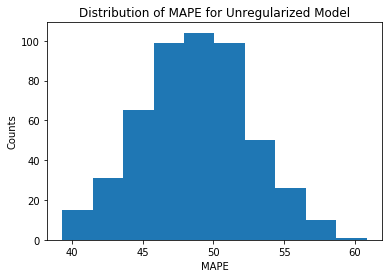

In [534]:
# Central limit theorem estimating a normal distribution of scores
plt.hist(mapes)
plt.title("Distribution of MAPE for Unregularized Model")
plt.xlabel("MAPE")
plt.ylabel("Counts")
plt.show()

In [ ]:
# Train and find MAPE of regularized model 500 times 
mapes2 = []
for i in range(500):
    model2 = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences = True, input_shape = (19,1), recurrent_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        keras.layers.LSTM(20, return_sequences = True),
        keras.layers.LSTM(20),
        keras.layers.Dense(12)
    ])

    model2.compile(loss="mse", optimizer="adam")
    history = model2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose = 0)
    y_pred2 = model2.predict(X_val, verbose = 0)
    y_pred_actual2 = y_scale.inverse_transform(y_pred2)
    mape2 = get_mape(y_pred_actual2, y_test)
    mapes2.append(mape2)

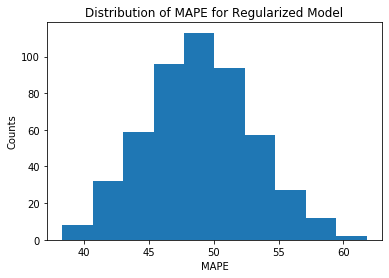

In [535]:
# Central limit theorem estimating a normal distribution of scores
plt.hist(mapes2)
plt.title("Distribution of MAPE for Regularized Model")
plt.xlabel("MAPE")
plt.ylabel("Counts")
plt.show()

In [495]:
# Saving data for future use
two_mapes = pd.DataFrame(zip(mapes, mapes2), columns = ["Non-reg-mape", "reg-mape"])
two_mapes.to_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Time Series Project\mapes.csv")

Now I will conduct a paired t-test. If the p-value of the test is less than 5%, then that means the underlying distributions of true MAPE scores for the two models are different.

In [500]:
two_mapes.describe().T

,count,mean,std,min,25%,50%,75%,max
Non-reg-mape,500.0,48.738345,3.762731,39.312319,46.011833,48.836375,51.230085,60.836722
reg-mape,500.0,48.960704,4.055817,38.331660,46.203191,48.847163,51.614209,61.785395


In [499]:
# Run two sample paired t test

from scipy.stats import ttest_rel

test_stat, p = ttest_rel(mapes, mapes2)
print("Statistic: %.3f, p-value: %.3f" % (test_stat, p))
if p >= 0.05:
    print("Fail to reject the null hypothesis; there is no difference in means between the two scores.")
else:
    print("Reject. Different dists")

Statistic: -0.901, p-value: 0.368
Fail to reject the null hypothesis; there is no difference in means between the two scores.


We can now conclude that there is no statistically significant difference in the average MAPE derived from the two models. 
<br>
<br>

Occam's razor suggests that simpler models shall be favored if the models have the same predictive capabilities. Hence, if I had to choose out of the deep learning models, I will choose the regularized model for deployment. However, keep in mind that our ARIMA model forecasted with much less MAPE and is more simple compared to deep learning models. Therefore, if I were to bring a model to production, I will choose the ARIMA model that was constructed in part one of this project.

# Conclusion

The best neural network models investigated with this project had an average mean absolute percentage error of about 49, resulting in a very underwhelming performance. As the No free lunch theorem suggests, using the most complicated models do not necessarily lead to the best results. This exercise proved the importance of understanding the different circumstances to use different models. LSTM models are by no means a high bias model. Rather, it is a very complicated model, and diagrams can often look esoteric. The complexity comes from the fact that it trains four different neural networks per LSTM cell. The main pitfall of using the model for this dataset is due to the lack of sample size. The model complexity led to a severe case of overfitting which led to suboptimal generalizaiton. The remedy for overfitting is regularization and more importantly for this case, acquiring more training data, which is not possible. Aside from tackling the overfitting issue, the model could have also been improved by trying different hyperparameters, such as learning rates, as well as trying different optimizers. However, I decided that my efforts to improve the deep learning model should be used on a different project, when the use of such models are more suited. Instead of creating the best forecasting deep learning model, the goal of this project was to explore deep learning methods for time series, and I was able to learn in depth about recurrent neural networks along the way. Therefore, I consider my efforts a success and will conclude my analysis of this dataset at this point. Though this specific problem did not warrant the use for a neural network, I see a great potential in using recurrent neural network for larger time series datasets, and I am excited to read academic papers that put these algorithms into use. 
<br>
<br>
For future projects, I would like to investigate the use of Transformers and other attention-based algorithms on larger time series datasets. I would also like to explore different hyperparameter tuning techniques for deep learning. 